This notebooks will introduce some basic concepts of Casadi.

First we import casadi and define a function to draw an expression graph.

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_expr(expr):
    return Image(dotgraph(expr).create_png())

# Creating Symbolic Expression Graphs

Now we will define a scalar expression "SX" symbol the represents the variable x.

In [39]:
x = ca.SX.sym('x')
x

SX(x)

We can create new expressions from the variable x.

In [40]:
y = -2*x**2
y

SX((-2*sq(x)))

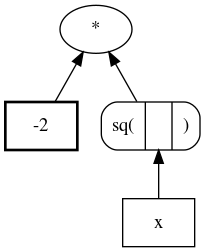

In [41]:
draw_expr(y)

# SX vs MX Expression Graphs

SX are scalar expression graphs, and MX are matrix expression graphs. SX are faster for simple operations, while MX are optimized for more advanced composition of function and matrix math.

Note that the SX matrix expression below is expanded into scalar expression, which can be useful for sparse matrices.

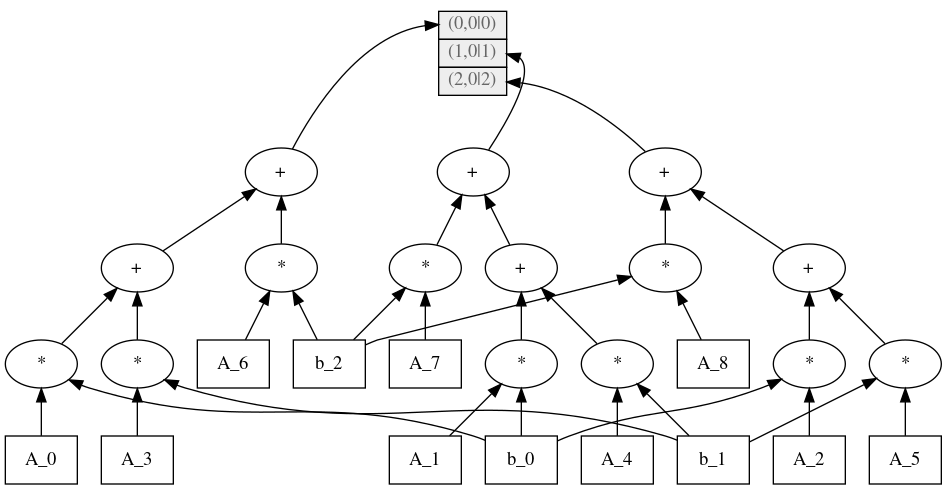

In [42]:
M = ca.SX.sym('A', 3, 3)
b = ca.SX.sym('b', 3)

draw_expr(ca.mtimes(M, b))

If instead we use an MX graph, the matrix operations are not expanded, and instead use a generic matrix multiplication method.

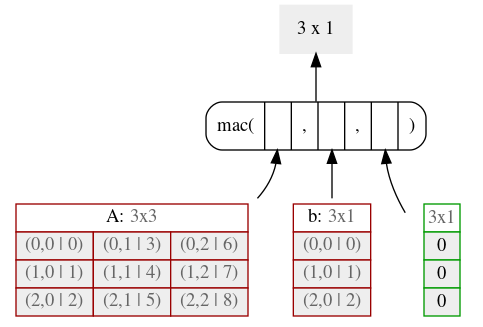

In [43]:
M = ca.MX.sym('A', 3, 3)
b = ca.MX.sym('b', 3)

draw_expr(ca.mtimes(M, b))

# Jacobian of Symbolic Expression Graph

The jacobian of an expression graph is useful for optimizatin and for control design. Casadi uses automatic differentiation so this is a straight forward function call for any casadi expression.

In [44]:
J = ca.jacobian(y, x)
J

SX((-2*(x+x)))

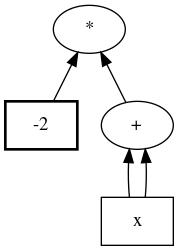

In [45]:
draw_expr(J)

# Functions

In [46]:
# name of function, list of input variables, list of output expressions, names of input, names of output
f = ca.Function('y', [x], [2*y], ['x'], ['y'])
f

Function(y:(x)->(y) SXFunction)

In [47]:
float(f(2.3))

-21.159999999999997

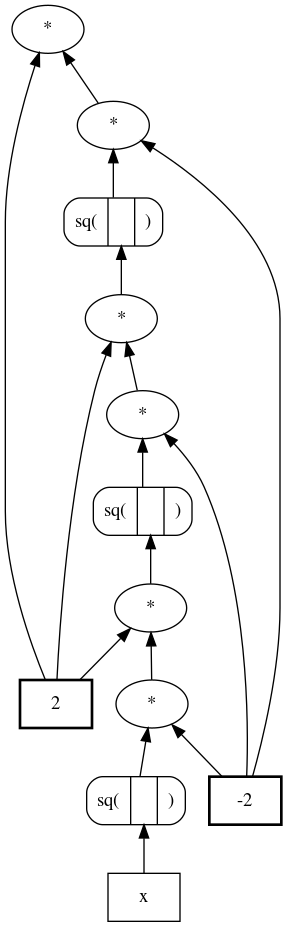

In [48]:
draw_expr(f(f(f(x))))

# Integration

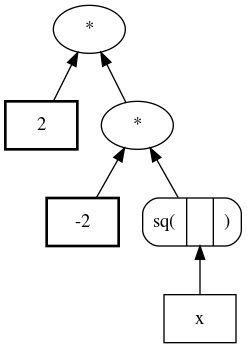

In [51]:
draw_expr(f(x))

In [68]:
import scipy.integrate
f = ca.Function('y', [x], [2*x + ca.sin(x)**2 + 6*ca.cos(x)], ['x'], ['y'])

In [69]:
%%timeit
res = scipy.integrate.solve_ivp(fun=lambda t, y: f(y), t_span=[0, 1], y0=[0], t_eval=np.arange(0, 1, 0.01))
res

4.75 ms ± 78.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
f_fast = ca.Function('y', [x], [2*y], ['x'], ['y'], {'jit': True})

In [71]:
%%timeit
res = scipy.integrate.solve_ivp(fun=lambda t, y: f_fast(y), t_span=[0, 1], y0=[0], t_eval=np.arange(0, 1, 0.01))
res

4.53 ms ± 85.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we show how to do a simple numerical integration, as might be needed in a simulation.

We are integrating the differential equation:

$\dot{x} = -2 x^2$

In [76]:
ode = {'x':x, 'ode':y}
dt = 0.1
F = ca.integrator('F', 'cvodes', ode, {'t0': 0, 'tf': dt})
F

Function(F:(x0,p[0],z0[0],rx0[0],rp[0],rz0[0])->(xf,qf[0],zf[0],rxf[0],rqf[0],rzf[0]) CvodesInterface)

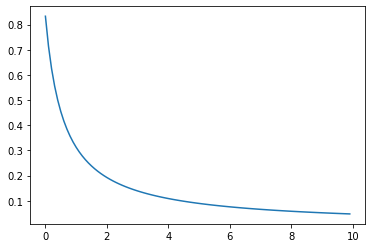

In [77]:
xi = 1
data = {
    't': [],
    'x': []
}
for t in np.arange(0, 10, dt):
    res = F(x0=xi)
    xi = res['xf']
    data['t'].append(t)
    data['x'].append(xi)
plt.plot(data['t'], data['x'])

You can also integrate with symbolic variables, which is often useful in optimization problems. This creates a new expression graph. Note this requires use of the MX "matrix" expression graph instead of SX.

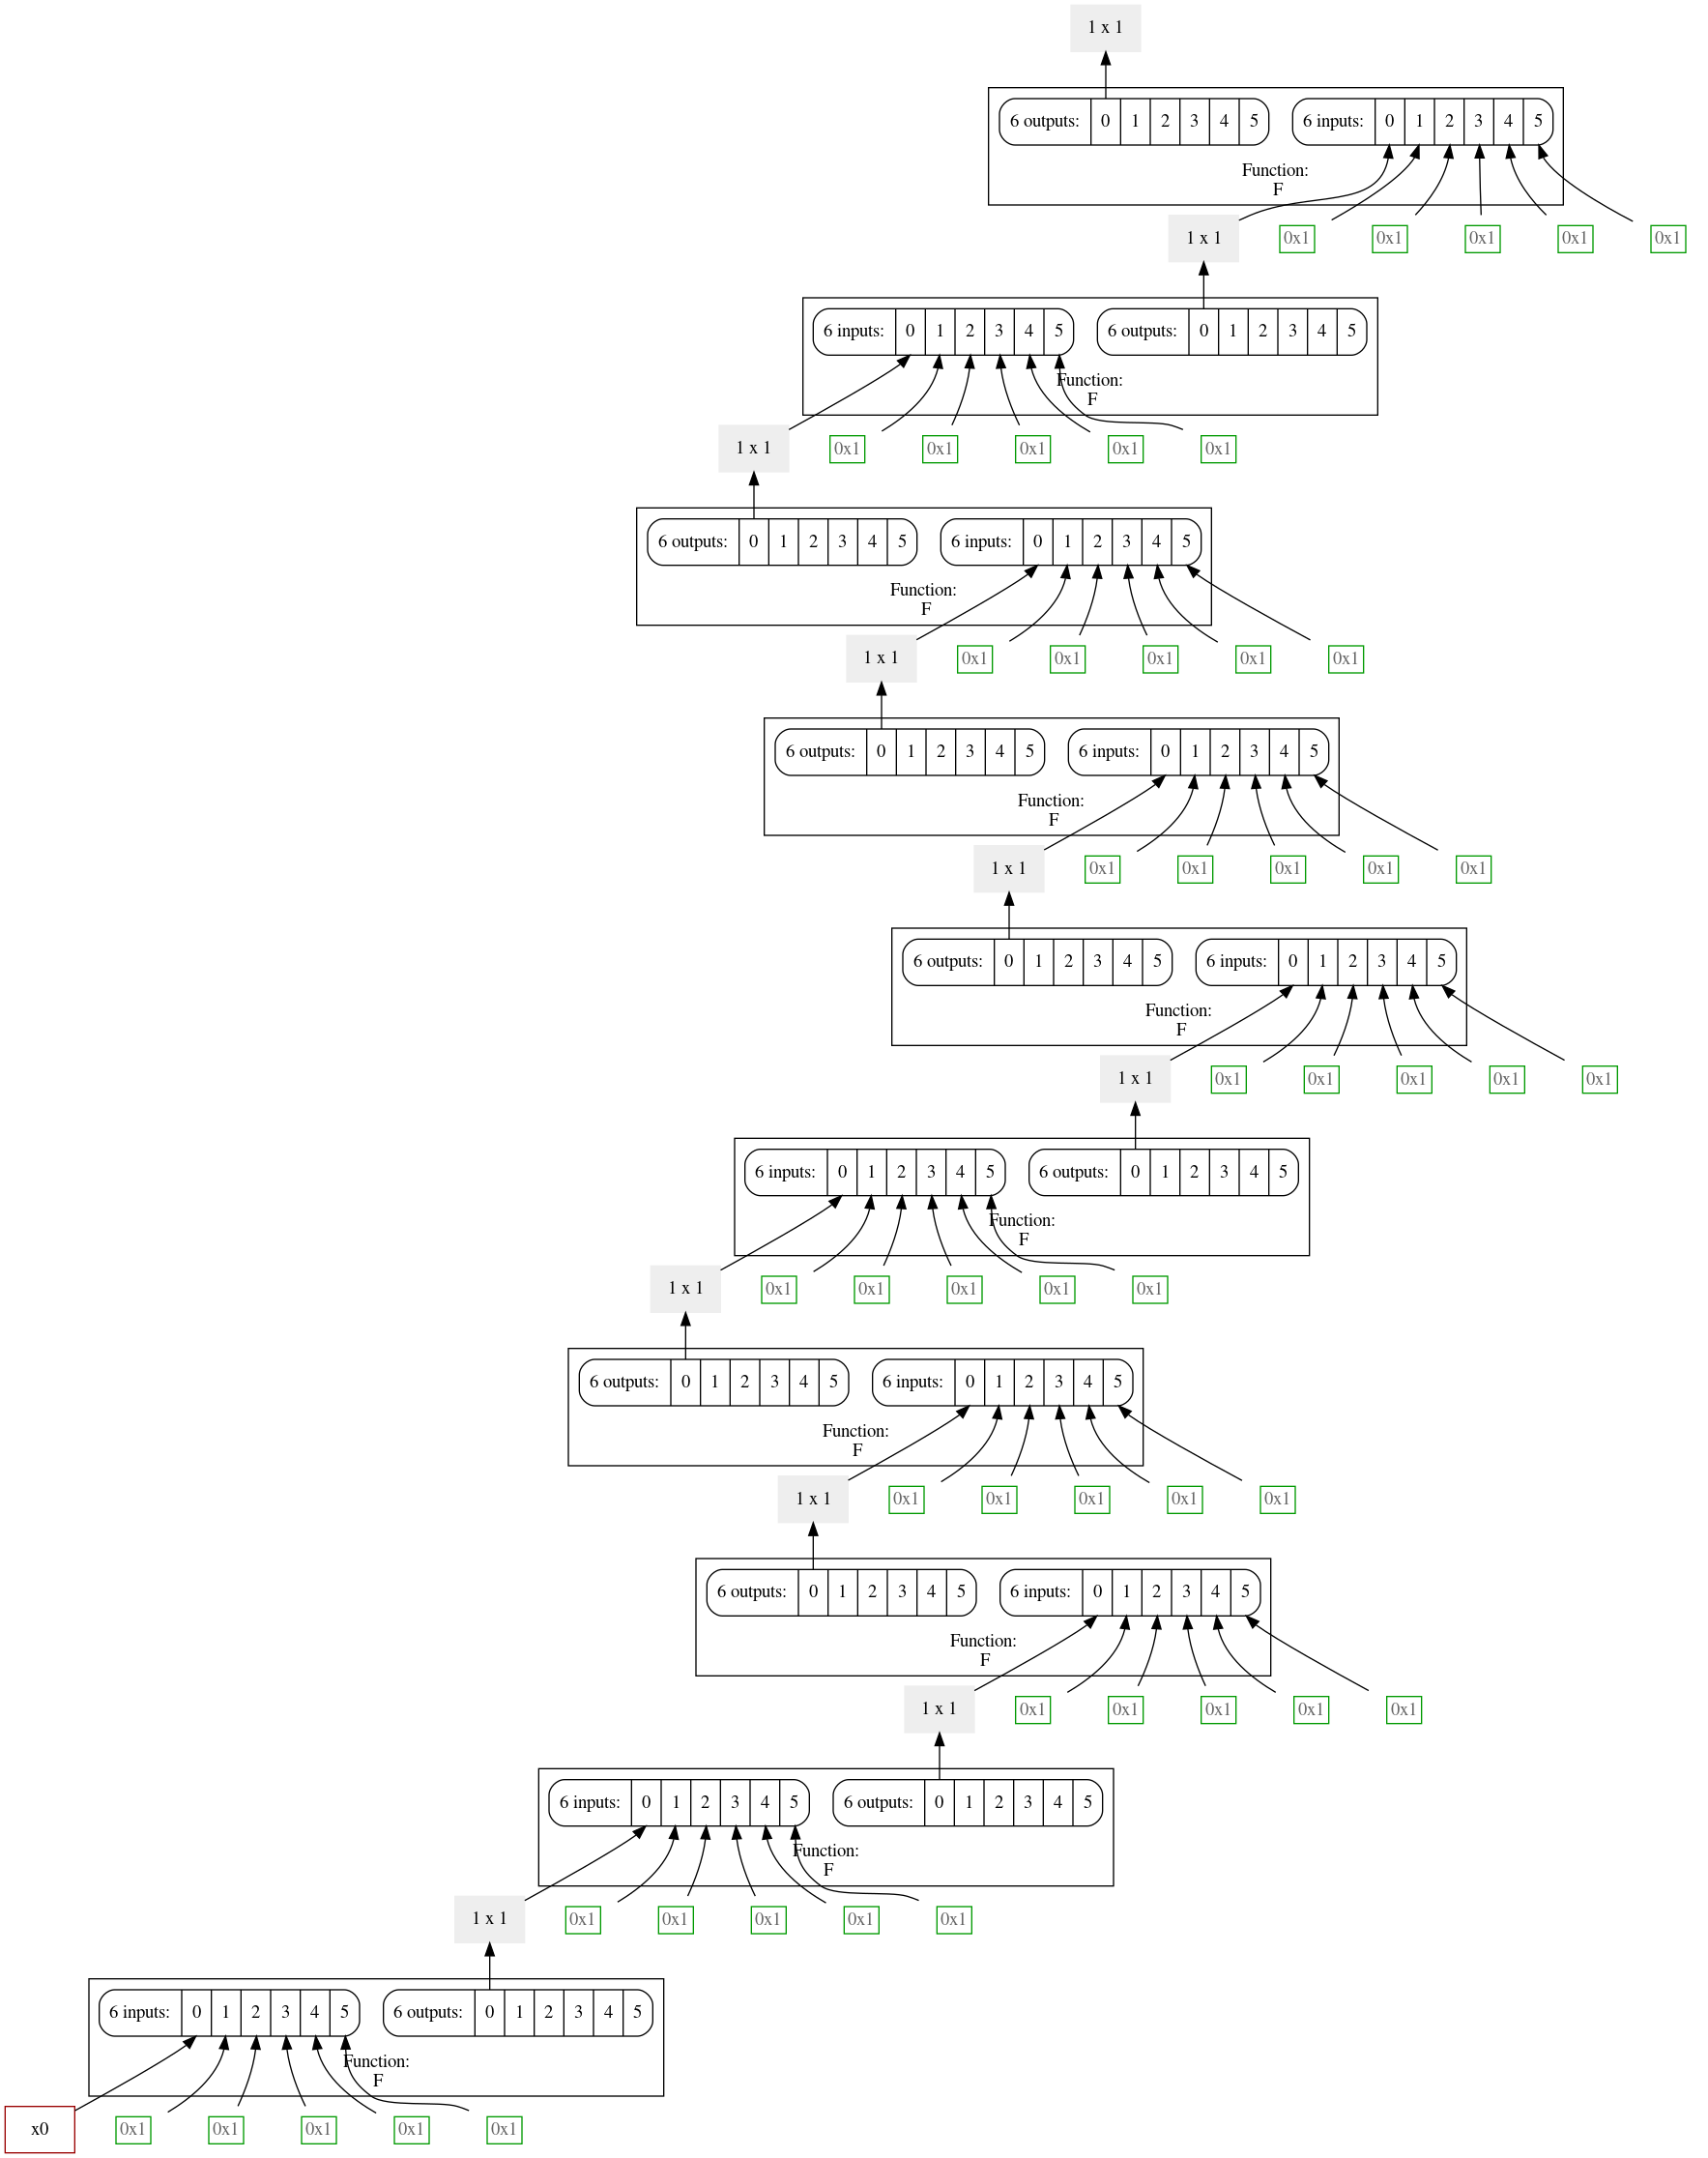

In [80]:
x0 = ca.MX.sym('x0')
xi = x0
data = {
    't': [],
    'x': []
}
for t in np.arange(0, 1, 0.1):
    res = F(x0=xi)
    xi = res['xf']
    data['t'].append(t)
    data['x'].append(xi)

draw_expr(xi)

# Code Generation

Any casadi function can converted into C code with the generate method. See the documentation for writing more than one function to the same file.

In [82]:
int_chain = ca.Function('int_chain', [x0], [xi], ['x0'], ['xi'])

In [91]:
import os
os.chdir('/tmp')
int_chain.generate('gen.c', dict(main=True, mex=False))
print(open('gen.c','r').read())

/* This file was automatically generated by CasADi.
   The CasADi copyright holders make no ownership claim of its contents. */
#ifdef __cplusplus
extern "C" {
#endif

/* How to prefix internal symbols */
#ifdef CODEGEN_PREFIX
  #define NAMESPACE_CONCAT(NS, ID) _NAMESPACE_CONCAT(NS, ID)
  #define _NAMESPACE_CONCAT(NS, ID) NS ## ID
  #define CASADI_PREFIX(ID) NAMESPACE_CONCAT(CODEGEN_PREFIX, ID)
#else
  #define CASADI_PREFIX(ID) gen_ ## ID
#endif

#include <math.h>
#include <stdio.h>
#include <string.h>

#ifndef casadi_real
#define casadi_real double
#endif

#ifndef casadi_int
#define casadi_int long long int
#endif

/* Add prefix to internal symbols */
#define casadi_f0 CASADI_PREFIX(f0)
#define casadi_f1 CASADI_PREFIX(f1)
#define casadi_s0 CASADI_PREFIX(s0)

/* Symbol visibility in DLLs */
#ifndef CASADI_SYMBOL_EXPORT
  #if defined(_WIN32) || defined(__WIN32__) || defined(__CYGWIN__)
    #if defined(STATIC_LINKED)
      #define CASADI_SYMBOL_EXPORT
    #else
      #define CASADI_SYMBO

CasADi - 2019-09-11 17:11:34 WARNING("The function "F", which is of type "CvodesInterface" cannot be code generated. The generation will proceed, but compilation of the code will not be possible.") [.../casadi/core/function_internal.cpp:2026]


In [87]:
!ls

1-Basics.ipynb	       4-Casadi-Inv-Pend.ipynb	gen.c		 source.dot
2-F16-Intro.ipynb      analysis.py		jit_tmp.c	 _temp.png
3-Mocap-Data.ipynb     data			__pycache__
4-Casadi-Basics.ipynb  data.json		RootLocus.ipynb
